# Assignment - 4
## Prem Sagar Malothu
## 22B0052

In [2]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'aiml-general-championship:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F71608%2F7895811%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240731%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240731T160003Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D96c5df5c9599d65577fdc4bd9081f0110dc50c675b0872c7913c5c9f05300cb0ebc74c79f07112231e488864d1c9ba1c0e7d9e72732033640ec443ecf3d0663434587c6590c586e34e4bf578a6b73c46b8f35ab28bf7f9a7792bf9e7e925ddf5ea1294e979536c888f6c066979cbb9fab480ae49a52d9b2b757a6c4eb01a2db472c047cb127c0e2db2ccd400d9ac441b93194411e3c0535ee581a40288b6d9e4a8bbe5036fdfd7691d039f0873a125c48c887b35ca418352079a8499ab6eb54aee3dda514ce4373208d9c14fa4865cff045c92bbc182e85c5944030cea63a84dd1dc8b8bf44057e14d6f3a70d514833b3003686a1769b709bbed20e50cfc1739'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 3073275416 bytes downloaded
Downloaded and uncompressed: aiml-general-championship
Data source import complete.


In [3]:
%matplotlib inline

# python libraties
import os, cv2,itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# ensure results are reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

In [4]:
data_dir = "/kaggle/input/aiml-general-championship"
print(os.listdir(data_dir))

['KCDH2024_Training_Input_10K', 'KCDH2024_Training_LesionGroupings.csv', 'KCDH2024_Test_Input', 'KCDH2024_Training_GroundTruth.csv', 'sample_submission.csv']


<h1>Loading Data... </h1>

In [5]:
img_data_dir = data_dir + r"/KCDH2024_Training_Input_10K/KCDH2024_Training_Input_10K"
all_image_path = glob(os.path.join(img_data_dir, '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}  # key - image filename,   value - path to image
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [6]:
len(imageid_path_dict)

9600

In [7]:
img = cv2.imread(imageid_path_dict["ISIC_0024308"])
img.shape

(450, 600, 3)

In [8]:
def compute_img_mean_std(image_paths):
    """
        computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224              # Size to resize..
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs

In [9]:
# means , stdevs = compute_img_mean_std(all_image_path)

In [10]:
# Store Values to save time in future..
norm_mean = [0.76696384, 0.54525656, 0.56884694]
norm_std = [0.13945772, 0.15192385, 0.16916788]

In [11]:
lesion_db = pd.read_csv(os.path.join(data_dir, 'KCDH2024_Training_LesionGroupings.csv'))
truth_db = pd.read_csv(os.path.join(data_dir, 'KCDH2024_Training_GroundTruth.csv'))

df = pd.merge(lesion_db, truth_db, on = 'image', how = 'inner')
df.drop("diagnosis_confirm_type", axis = 1, inplace = True)
df['path'] = df['image'].map(imageid_path_dict.get)
df

,image,lesion_id,MEL,NV,BCC,AKIEC,BKL,DF,VASC,path
0,ISIC_0024306,HAM_0000550,0,1,0,0,0,0,0,/kaggle/input/aiml-general-championship/KCDH20...
1,ISIC_0024307,HAM_0003577,0,1,0,0,0,0,0,/kaggle/input/aiml-general-championship/KCDH20...
2,ISIC_0024308,HAM_0001477,0,1,0,0,0,0,0,/kaggle/input/aiml-general-championship/KCDH20...
3,ISIC_0024309,HAM_0000484,0,1,0,0,0,0,0,/kaggle/input/aiml-general-championship/KCDH20...
4,ISIC_0024310,HAM_0003350,1,0,0,0,0,0,0,/kaggle/input/aiml-general-championship/KCDH20...
...,...,...,...,...,...,...,...,...,...,...
10010,ISIC_0034316,HAM_0004304,1,0,0,0,0,0,0,None
10011,ISIC_0034317,HAM_0006376,1,0,0,0,0,0,0,None
10012,ISIC_0034318,HAM_0000344,0,0,0,0,1,0,0,None
10013,ISIC_0034319,HAM_0000747,0,1,0,0,0,0,0,None


In [12]:
# Remove the rows not containg path to images..
df = df[df['path'].notna()]
df

,image,lesion_id,MEL,NV,BCC,AKIEC,BKL,DF,VASC,path
0,ISIC_0024306,HAM_0000550,0,1,0,0,0,0,0,/kaggle/input/aiml-general-championship/KCDH20...
1,ISIC_0024307,HAM_0003577,0,1,0,0,0,0,0,/kaggle/input/aiml-general-championship/KCDH20...
2,ISIC_0024308,HAM_0001477,0,1,0,0,0,0,0,/kaggle/input/aiml-general-championship/KCDH20...
3,ISIC_0024309,HAM_0000484,0,1,0,0,0,0,0,/kaggle/input/aiml-general-championship/KCDH20...
4,ISIC_0024310,HAM_0003350,1,0,0,0,0,0,0,/kaggle/input/aiml-general-championship/KCDH20...
...,...,...,...,...,...,...,...,...,...,...
9595,ISIC_0033901,HAM_0002342,1,0,0,0,0,0,0,/kaggle/input/aiml-general-championship/KCDH20...
9596,ISIC_0033902,HAM_0000048,1,0,0,0,0,0,0,/kaggle/input/aiml-general-championship/KCDH20...
9597,ISIC_0033903,HAM_0003367,0,1,0,0,0,0,0,/kaggle/input/aiml-general-championship/KCDH20...
9598,ISIC_0033904,HAM_0005820,0,1,0,0,0,0,0,/kaggle/input/aiml-general-championship/KCDH20...


In [13]:
# Convert 7 different columns of different lesisons to single ...

cell_type_idx = []

for index, row in df.iterrows():
    cell_type_idx_row = row["MEL"], row["NV"], row["BCC"], row["AKIEC"], row["BKL"], row["DF"], row["VASC"]
    cell_type_idx.append(cell_type_idx_row.index(1))

# Assign a new column..
df["cell_type_idx"] = cell_type_idx

# Drop older columns..
df.drop( columns = ["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"], inplace = True)

df.head()

<ipython-input-13-e8cf84c7420c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cell_type_idx"] = cell_type_idx
<ipython-input-13-e8cf84c7420c>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop( columns = ["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"], inplace = True)


,image,lesion_id,path,cell_type_idx
0,ISIC_0024306,HAM_0000550,/kaggle/input/aiml-general-championship/KCDH20...,1
1,ISIC_0024307,HAM_0003577,/kaggle/input/aiml-general-championship/KCDH20...,1
2,ISIC_0024308,HAM_0001477,/kaggle/input/aiml-general-championship/KCDH20...,1
3,ISIC_0024309,HAM_0000484,/kaggle/input/aiml-general-championship/KCDH20...,1
4,ISIC_0024310,HAM_0003350,/kaggle/input/aiml-general-championship/KCDH20...,0


In [14]:
# Determine how many images are associated with each lesion_id ?
df_undup = df.groupby('lesion_id').count()

# Filter out lesion_id's that have only one image associated with it
df_undup = df_undup[df_undup['image'] == 1]
df_undup.reset_index(inplace=True)
df_undup.head()

,lesion_id,image,path,cell_type_idx
0,HAM_0000001,1,1,1
1,HAM_0000003,1,1,1
2,HAM_0000004,1,1,1
3,HAM_0000007,1,1,1
4,HAM_0000008,1,1,1


In [15]:
df_undup = df.groupby('lesion_id').count()
df_undup.head()

# Filter out lesion_id's that have only one image associated with it
df_undup = df_undup[df_undup['image'] == 1]
df_undup.reset_index(inplace=True)
df_undup[:]

,lesion_id,image,path,cell_type_idx
0,HAM_0000001,1,1,1
1,HAM_0000003,1,1,1
2,HAM_0000004,1,1,1
3,HAM_0000007,1,1,1
4,HAM_0000008,1,1,1
...,...,...,...,...
5592,HAM_0007622,1,1,1
5593,HAM_0007623,1,1,1
5594,HAM_0007624,1,1,1
5595,HAM_0007626,1,1,1


In [16]:
# Identify lesion_id's that have duplicate images and those that have only one image.
def get_duplicates(x):
    unique_list = list(df_undup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'

# Create a new colum that is a copy of the lesion_id column
df['duplicates'] = df['lesion_id']
# Apply the function to this new column
df['duplicates'] = df['duplicates'].apply(get_duplicates)
df.head()

<ipython-input-16-b028af88ce2f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['duplicates'] = df['lesion_id']
<ipython-input-16-b028af88ce2f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['duplicates'] = df['duplicates'].apply(get_duplicates)


,image,lesion_id,path,cell_type_idx,duplicates
0,ISIC_0024306,HAM_0000550,/kaggle/input/aiml-general-championship/KCDH20...,1,unduplicated
1,ISIC_0024307,HAM_0003577,/kaggle/input/aiml-general-championship/KCDH20...,1,unduplicated
2,ISIC_0024308,HAM_0001477,/kaggle/input/aiml-general-championship/KCDH20...,1,unduplicated
3,ISIC_0024309,HAM_0000484,/kaggle/input/aiml-general-championship/KCDH20...,1,unduplicated
4,ISIC_0024310,HAM_0003350,/kaggle/input/aiml-general-championship/KCDH20...,0,duplicated


In [17]:
df['duplicates'].value_counts()

,count
duplicates,
unduplicated,5597
duplicated,4003


In [18]:
# Filter out images that don't have duplicates (count = 1)  (Removed augmented images)
# We will use this data to get validation set..
df_undup = df[df['duplicates'] == 'unduplicated']
df_undup.shape

(5597, 5)

In [19]:
# Create a val set using df as none of these images have augmented duplicates in the training set now..
y = df_undup['cell_type_idx']
_, df_val = train_test_split(df_undup, test_size=0.2, random_state=101, stratify=y)
df_val.shape

(1120, 5)

In [20]:
df_val['cell_type_idx'].value_counts()

,count
cell_type_idx,
1,891
4,89
0,52
2,37
3,30
6,13
5,8


In [21]:
# Remove the validation rows from the original data to get training rows..

# This function identifies if an image is part of the train or val set.
def get_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image'])
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# Identify train and val rows..
# Create a new colum that is a copy of the image column
df['train_or_val'] = df['image']

# Apply the function to this new column
df['train_or_val'] = df['train_or_val'].apply(get_val_rows)

# Filter out training rows
df_train = df[df['train_or_val'] == 'train']
df_train = df_train.drop('train_or_val', axis = 1, inplace = False)
print(len(df_train))
print(len(df_val))

<ipython-input-21-a172c2086e7d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['train_or_val'] = df['image']


8480
1120


<ipython-input-21-a172c2086e7d>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['train_or_val'] = df['train_or_val'].apply(get_val_rows)


In [22]:
df_train['cell_type_idx'].value_counts()

# Duplicate rows to balance the number of rows in 7 classes..
data_aug_rate = [6.3,1.025,13,19.8,6.1,56.4,47.7]

# Iterate over unique values of 'cell_type_idx'
for i in df_train['cell_type_idx'].unique():

    if data_aug_rate[i] > 1:

        # Filter the DataFrame for the current value of 'cell_type_idx'
        filtered_df = df_train[df_train['cell_type_idx'] == i]

        # Duplicate rows based on the data augmentation rate for this value of 'cell_type_idx'
        duplicated_rows = filtered_df.sample(frac=data_aug_rate[i] - 1, replace=True)

        # Concatenate the original DataFrame with the duplicated rows
        df_train = pd.concat([df_train, duplicated_rows], ignore_index=True)

df_train['cell_type_idx'].value_counts()

,count
cell_type_idx,
0,6067
6,5963
2,5954
5,5922
4,5893
3,5881
1,5705


<h1>DataSet Spliiting</h1>

In [23]:
len(df_train)

41385

In [24]:
# Split the test set again in a validation set and a true test set:

df_val, df_test = train_test_split(df_val, test_size=0.5)
df_train = df_train.reset_index()
df_val = df_val.reset_index()
df_test = df_test.reset_index()

In [25]:
print(len(df_test))
df_test['cell_type_idx'].value_counts()

560


,count
cell_type_idx,
1,453
4,40
2,23
0,22
3,16
6,5
5,1


<h1>Define Model</h1>

In [26]:
# feature_extract is a boolean that defines finetuning or feature extracting.
# If feature_extract = False, the model is finetuned and all model parameters are updated.
# If feature_extract = True, only the last layer parameters are updated, the others remain fixed.

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [27]:

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set
    model_ft = None
    input_size = 0

    if model_name == "efficientnet":
        model_ft = models.efficientnet_b3(pretrained=True, progress=True)
        set_parameter_requires_grad(model_ft, feature_extract)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [28]:
torch.cuda.is_available()

True

In [29]:
# Define a new model variable..

model_name = "efficientnet"
num_classes = 7
feature_extract = False
# Initialize the model
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Define the device:
device = torch.device('cuda:0')
# device = torch.device('cpu') # If using cpu
# Put the model on the device:
model = model_ft.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 101MB/s]


<H1>Augmenting Data...</H1>

In [30]:
# define the transformation of the train images.
train_transform = transforms.Compose([transforms.Resize((input_size,input_size)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                      transforms.ToTensor(),
                                      transforms.Normalize(norm_mean, norm_std)])


# define the transformation of the val images.
val_transform = transforms.Compose([transforms.Resize((input_size,input_size)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])

# define the transformation of the test images.
test_transform = transforms.Compose([transforms.Resize((input_size,input_size)),
                                     transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])

In [31]:
# Define a pytorch dataloader for dataset..
class HAM10000(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(self.df['path'][index])
        y = torch.tensor(int(self.df['cell_type_idx'][index]))

        if self.transform:
            X = self.transform(X)

        return X, y

In [32]:
# Define the training set using the table train_df and using the defined transitions (train_transform)
training_set = HAM10000(df_train, transform=train_transform)
train_loader = DataLoader(training_set, batch_size=32, shuffle=True, num_workers=4)

# Same for the validation set:
validation_set = HAM10000(df_val, transform=train_transform)
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=4)

# Same for the test set:
test_set = HAM10000(df_test, transform=train_transform)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [33]:
# this function is used during training process, to calculate the loss and accuracy
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [34]:
total_loss_train, total_acc_train = [],[]

def train(train_loader, model, criterion, optimizer, epoch, threshold_batch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):

        if threshold_batch and i>= threshold_batch:
            break

        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg

In [35]:
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()

    total_val_loss = []
    total_val_acc = []

    with torch.no_grad():
        for i, data in tqdm(enumerate(val_loader)):

            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
            val_loss.update(criterion(outputs, labels).item())

            if (i + 1) % 3 == 0:
                total_val_acc.append(val_acc.avg)
                total_val_loss.append(val_loss.avg)

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return  total_val_loss , total_val_acc

In [36]:
# Start Training..
def train_model(epoch_num, lr, optimizer_func = optim.Adam, threshold_batch = None, criterion = nn.CrossEntropyLoss()):

    best_val_acc = 0
    total_loss_val, total_acc_val = [],[]
    for epoch in tqdm(range(1, epoch_num+1)):

        # set optimizer and loss function
        optimizer = optimizer_func(model.parameters(), lr= lr)
        criterion = criterion.to(device)

        loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch, threshold_batch)
        loss_val, acc_val = validate(val_loader, model, criterion , optimizer, epoch)
        total_loss_val += loss_val
        total_acc_val += acc_val
    return total_loss_val, total_acc_val

In [37]:
# Store Training data..
total_loss_val, total_acc_val = [],[]
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam

In [38]:
# Training - 1st
data = train_model(1,1e-3)
total_loss_val += data[0]
total_acc_val += data[1]

  0%|          | 0/1 [00:00<?, ?it/s]

[epoch 1], [iter 100 / 1294], [train loss 1.42315], [train acc 0.56094]
[epoch 1], [iter 200 / 1294], [train loss 1.10242], [train acc 0.64422]
[epoch 1], [iter 300 / 1294], [train loss 0.96117], [train acc 0.68219]
[epoch 1], [iter 400 / 1294], [train loss 0.86594], [train acc 0.70992]
[epoch 1], [iter 500 / 1294], [train loss 0.80614], [train acc 0.72919]
[epoch 1], [iter 600 / 1294], [train loss 0.75562], [train acc 0.74484]
[epoch 1], [iter 700 / 1294], [train loss 0.71473], [train acc 0.75705]
[epoch 1], [iter 800 / 1294], [train loss 0.67663], [train acc 0.76789]
[epoch 1], [iter 900 / 1294], [train loss 0.64547], [train acc 0.77840]
[epoch 1], [iter 1000 / 1294], [train loss 0.62167], [train acc 0.78634]
[epoch 1], [iter 1100 / 1294], [train loss 0.59949], [train acc 0.79355]
[epoch 1], [iter 1200 / 1294], [train loss 0.57810], [train acc 0.79984]



0it [00:00, ?it/s]
1it [00:02,  2.76s/it]
2it [00:02,  1.22s/it]
3it [00:03,  1.29it/s]
4it [00:03,  1.89it/s]
5it [00:05,  1.03it/s]
6it [00:05,  1.46it/s]
7it [00:05,  2.00it/s]
9it [00:06,  1.76it/s]
10it [00:06,  2.23it/s]
11it [00:06,  2.72it/s]
12it [00:06,  3.39it/s]
13it [00:08,  1.96it/s]
15it [00:08,  3.07it/s]
18it [00:08,  2.04it/s]
100%|██████████| 1/1 [11:04<00:00, 664.81s/it]

------------------------------------------------------------
[epoch 1], [val loss 0.26412], [val acc 0.89583]
------------------------------------------------------------


In [39]:
# Check results on test dataset..
validate(test_loader, model, criterion, optimizer, 1)

18it [00:07,  2.36it/s]

------------------------------------------------------------
[epoch 1], [val loss 0.33089], [val acc 0.90278]
------------------------------------------------------------


([0.33416767170031864,
  0.3375296654800574,
  0.314282341963715,
  0.3413132559508085,
  0.31568743934233984,
  0.3308904506266117],
 [0.9166666666666666,
  0.921875,
  0.9131944444444444,
  0.9114583333333334,
  0.9125,
  0.9027777777777778])

In [40]:
# Training - 2nd..
train_model(1,1e-5,threshold_batch = 300)

  0%|          | 0/1 [00:00<?, ?it/s]

[epoch 1], [iter 100 / 1294], [train loss 0.30054], [train acc 0.88438]
[epoch 1], [iter 200 / 1294], [train loss 0.28221], [train acc 0.89500]
[epoch 1], [iter 300 / 1294], [train loss 0.26699], [train acc 0.90083]



0it [00:00, ?it/s]
1it [00:01,  1.54s/it]
2it [00:01,  1.42it/s]
3it [00:01,  2.19it/s]
4it [00:01,  3.10it/s]
5it [00:03,  1.69it/s]
6it [00:03,  2.33it/s]
7it [00:03,  3.03it/s]
8it [00:03,  3.84it/s]
9it [00:04,  1.75it/s]
11it [00:04,  2.75it/s]
13it [00:05,  2.29it/s]
15it [00:06,  3.16it/s]
16it [00:06,  3.68it/s]
18it [00:06,  2.57it/s]
100%|██████████| 1/1 [02:36<00:00, 156.53s/it]

------------------------------------------------------------
[epoch 1], [val loss 0.26022], [val acc 0.90799]
------------------------------------------------------------


([0.2901752442121506,
  0.2502775887648265,
  0.2372197194231881,
  0.2482812019685904,
  0.24008976419766745,
  0.2602173545294338],
 [0.8854166666666666,
  0.90625,
  0.9166666666666666,
  0.9088541666666666,
  0.9166666666666666,
  0.9079861111111112])

In [41]:
# Check results on test dataset..
validate(test_loader, model, criterion, optimizer, 1)

18it [00:09,  1.92it/s]

------------------------------------------------------------
[epoch 1], [val loss 0.32327], [val acc 0.88715]
------------------------------------------------------------


([0.2864062860608101,
  0.29043921704093617,
  0.26936644150151146,
  0.3075605779886246,
  0.3235920826594035,
  0.3232651621931129],
 [0.90625,
  0.9010416666666666,
  0.9097222222222222,
  0.9036458333333334,
  0.8895833333333333,
  0.8871527777777778])

In [42]:
# Training - 3rd..
train_model(1,1e-5,threshold_batch = 300)

  0%|          | 0/1 [00:00<?, ?it/s]

[epoch 1], [iter 100 / 1294], [train loss 0.24519], [train acc 0.90625]
[epoch 1], [iter 200 / 1294], [train loss 0.23821], [train acc 0.91266]
[epoch 1], [iter 300 / 1294], [train loss 0.23806], [train acc 0.91146]



0it [00:00, ?it/s]
1it [00:02,  2.91s/it]
2it [00:03,  1.29s/it]
3it [00:03,  1.24it/s]
4it [00:03,  1.80it/s]
5it [00:04,  1.13it/s]
6it [00:05,  1.61it/s]
7it [00:05,  2.13it/s]
9it [00:06,  1.89it/s]
10it [00:06,  2.38it/s]
11it [00:06,  2.88it/s]
13it [00:07,  2.22it/s]
15it [00:08,  3.19it/s]
18it [00:08,  2.10it/s]
100%|██████████| 1/1 [02:37<00:00, 157.20s/it]

------------------------------------------------------------
[epoch 1], [val loss 0.28835], [val acc 0.90799]
------------------------------------------------------------


([0.3012520521879196,
  0.24251514052351317,
  0.22721736381451288,
  0.24214481996993223,
  0.233837332824866,
  0.2883496785329448],
 [0.8958333333333334,
  0.9166666666666666,
  0.9236111111111112,
  0.9166666666666666,
  0.925,
  0.9079861111111112])

In [43]:
# Check results on test dataset..
validate(test_loader, model, criterion, optimizer, 1)

18it [00:07,  2.43it/s]

------------------------------------------------------------
[epoch 1], [val loss 0.31783], [val acc 0.88542]
------------------------------------------------------------


([0.31517065068085987,
  0.33513730267683667,
  0.2905214313003752,
  0.3199118400613467,
  0.3194691717624664,
  0.31783368893795544],
 [0.8958333333333334,
  0.9010416666666666,
  0.9097222222222222,
  0.8958333333333334,
  0.8875,
  0.8854166666666666])

<h1> Analaysis Of Accuracies.. </h1>

In [44]:
total_loss_val

[0.2944374581178029,
 0.22482739140590033,
 0.21506504880057442,
 0.22924607247114182,
 0.24172366460164388,
 0.26412028902106816]

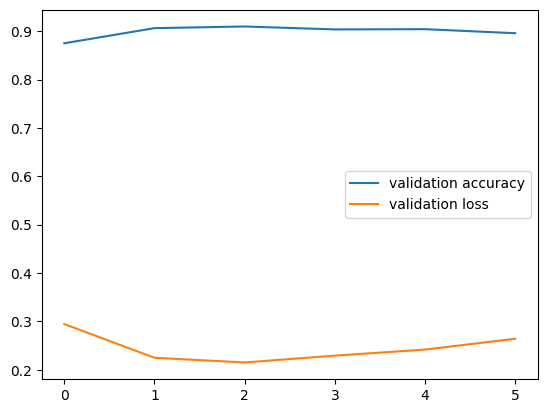

In [45]:
# Analysing accuracy and loss of validation data over the model..

fig = plt.figure(num = 1)
fig2 = fig.add_subplot(1,1,1)
fig2.plot(total_acc_val, label = 'validation accuracy')
fig2.plot(total_loss_val, label = 'validation loss')

plt.legend()
plt.show()

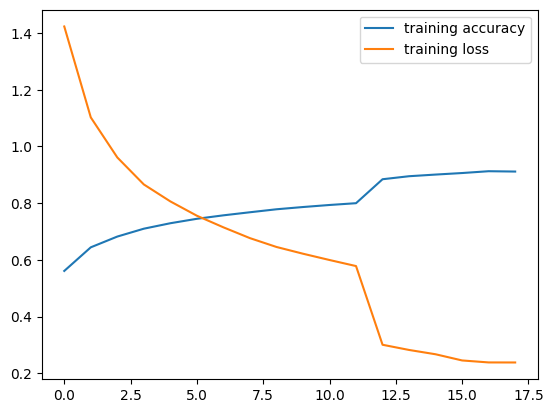

In [46]:
# Analysing accuracy and loss of training data over the model..

fig = plt.figure(num=1)
fig1 = fig.add_subplot(1,1,1)
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.plot(total_loss_train, label = 'training loss')

plt.legend()
plt.show()


In [47]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

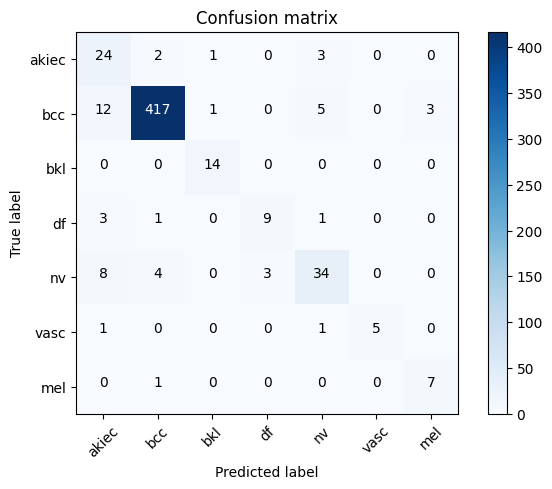

In [48]:
# This is Validation data evaluation

model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix for the validation matrix..
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix..
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


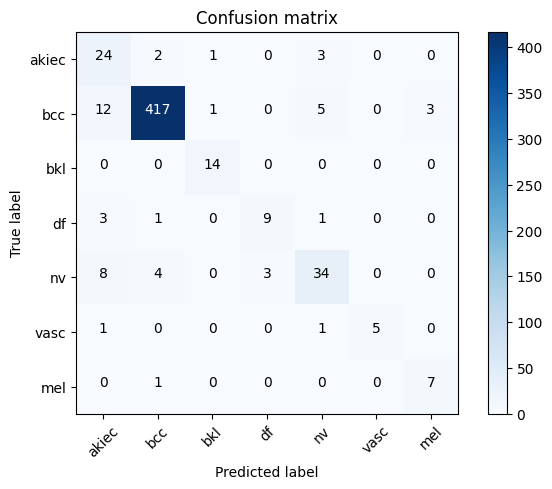

In [49]:
# This is test data evaluation

model.eval()
test_y_label = []
test_y_predict = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        test_y_label.extend(labels.cpu().numpy())
        test_y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix for the test data..
confusion_mtx_test = confusion_matrix(test_y_label, test_y_predict)

# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

In [50]:
# Generate a validation classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.50      0.80      0.62        30
         bcc       0.98      0.95      0.97       438
         bkl       0.88      1.00      0.93        14
          df       0.75      0.64      0.69        14
          nv       0.77      0.69      0.73        49
        vasc       1.00      0.71      0.83         7
         mel       0.70      0.88      0.78         8

    accuracy                           0.91       560
   macro avg       0.80      0.81      0.79       560
weighted avg       0.92      0.91      0.91       560



In [51]:
# Generate a test classification report
report = classification_report(test_y_label, test_y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.44      0.64      0.52        22
         bcc       0.99      0.94      0.96       453
         bkl       0.73      0.83      0.78        23
          df       0.47      0.50      0.48        16
          nv       0.59      0.75      0.66        40
        vasc       0.50      1.00      0.67         1
         mel       0.80      0.80      0.80         5

    accuracy                           0.89       560
   macro avg       0.65      0.78      0.70       560
weighted avg       0.91      0.89      0.90       560



Text(0, 0.5, 'Fraction classified incorrectly')

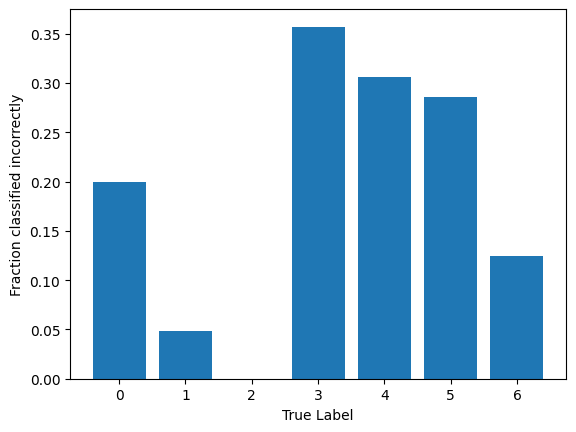

In [52]:
# True vs Incoorect classified analysis for validation data

label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

Text(0, 0.5, 'Fraction classified incorrectly')

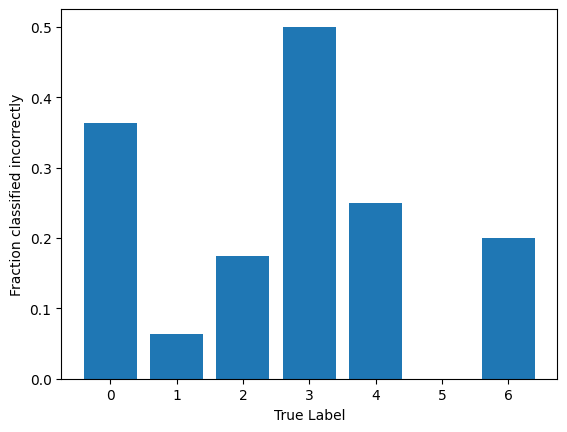

In [53]:
# True vs Incoorect classified analysis for test data

label_frac_error = 1 - np.diag(confusion_mtx_test) / np.sum(confusion_mtx_test, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

<h1> Predictions... </h1>

In [54]:
# Get data..
img_data_dir = data_dir + r"/KCDH2024_Test_Input/KCDH2024_Test_Input"
all_image_path = glob(os.path.join(img_data_dir, '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}  # key - image filename,   value - path to image
len(imageid_path_dict)

1512

In [55]:
# Header of txt file..
text = "ID,Class\n"

# Rows ..
model.eval()
with torch.no_grad():
    for imagename, path in tqdm(imageid_path_dict.items()):
         X = Image.open(path)
         X = test_transform(X)
         X = Variable(X).to(device)
         output = model(X.unsqueeze(0))
         prediction = output.max(1, keepdim=True)[1].item()
         text += f"{imagename},{prediction}\n"

100%|██████████| 1512/1512 [00:38<00:00, 39.54it/s]


In [56]:
with open(f'predictions.csv', 'w') as txtfile:
    txtfile.write(text)